In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
!pip install -e ../

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

from model.data import prepare_dataset
from model.model_selection import train_last_week_split
from model.model_selection import plot_roc_curve
from model.model import build_model

## ROC-curve
Le'ts plot ROC curve for train and hold-out set. Then compare our results to random picking.

In [3]:
data = prepare_dataset(Path("../data/"))
(X_tr, y_tr), (X_te, y_te) = train_last_week_split(data, week=48, full_training=False)

              precision    recall  f1-score   support

       False       0.78      0.84      0.81     74969
        True       0.83      0.76      0.79     74969

   micro avg       0.80      0.80      0.80    149938
   macro avg       0.80      0.80      0.80    149938
weighted avg       0.80      0.80      0.80    149938

              precision    recall  f1-score   support

       False       0.99      0.82      0.90     78467
        True       0.07      0.65      0.12      1533

   micro avg       0.82      0.82      0.82     80000
   macro avg       0.53      0.74      0.51     80000
weighted avg       0.97      0.82      0.89     80000



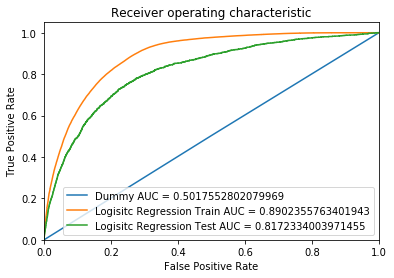

In [4]:
clf = build_model().fit(X_tr, y_tr)
y_te_lr = clf.predict_proba(X_te)
y_tr_lr = clf.predict_proba(X_tr)

print(classification_report(y_tr, clf.predict(X_tr)))
print(classification_report(y_te, clf.predict(X_te)))

# Make random predictions
dummy = DummyClassifier().fit(X_tr, y_tr)
y_te_dummy = dummy.predict_proba(X_te)
y_tr_dummy = dummy.predict_proba(X_tr)

ax = plot_roc_curve(y_te, y_te_dummy[:, 1], "Dummy")
plot_roc_curve(y_tr, y_tr_lr[:, 1], "Logisitc Regression Train")
plot_roc_curve(y_te, y_te_lr[:, 1], "Logisitc Regression Test")
plt.legend()

Higher scores on training set indicate overfitting, but increasing regularisation (small values of $C$) will affect test score as well. Possible solutions are to search for more descriminative features (while removing uninformative) or try to fit more complex algorithm (SVM, Trees, NNs) with stronger regularisation. 

## Cross-validation

In [5]:
from model.model_selection import xy, LastIntervalSplitCV, HomogenousSplitCV, cross_val_score
(X_tr, y_tr), (X_te, y_te) = train_last_week_split(data, week=49)

In [6]:
# scikit-learn still lacks time-series CV https://github.com/scikit-learn/scikit-learn/issues/6322
# Therefore using custom CV strategies.
# Pessimistic scenario: It should take into account the case when w=49 comes from a bit different distribution.

scores = list(cross_val_score(build_model(), X_tr, y_tr, cv=HomogenousSplitCV(n_splits=5)))
print("AUC = {:.4g}, error = {:.4g}".format(np.mean(scores), np.std(scores)))

AUC = 0.7781, error = 0.03639


In [7]:
# Classic one leave-one-out cross-validation for ordered data. It should be more accurate estimate for w=49

scores = list(cross_val_score(build_model(), X_tr, y_tr, cv=LastIntervalSplitCV(n_splits=5)))
print("AUC = {:.4g}, error = {:.4g}".format(np.mean(scores), np.std(scores)))

AUC = 0.8087, error = 0.003351
